# Face Identification and Adversarial Attacks
**Projet Deep Learning for Images**

Auteurs : Elise Chin, Mathilde Da Cruz


# Abstract

Résumer en qqlq lignes

# Introduction

Pbmatique + solutions déployées

La tâche que l'on souhaite résoudre ici est une tâche d'identification (*Face Identification*) : étant donné l'image d'un visage d'une personne inconnue, on souhaite identifier le nom de cette personne en se basant sur une banque d'images de personnes déjà identifiées. Nous nous plaçons dans un contexte close set : Nous savons donc déjà que la personne que l'on veut identifier est une des personnes de notre banque. On peut voir le problème comme une tâche de classification multi-classe, où chaque classe représente une personne (un label est le nom d'une personne).


__Première idée__

https://www.linkedin.com/pulse/effectively-tackling-multiclass-problem-siamese-models-amit-raj?trk=public_profile_article_view

Traditionnellement, pour résoudre une tâche de classification d'images, on entraîne un CNN qui prend en entrée une image et donne en sortie une distribution de probabilités sur les classes, à l'aide d'un classifieur softmax.

Il y a cependant plusieurs limites à cette approche dans certains cas : 
- Si le dataset possède des centaines voir des milliers de classes (en l'occurrence pour LFW, il y a 5749 classes dont 1680 classes avec au moins deux images distinctes), utiliser un classifieur softmax engendrera des calculs très coûteux et un entraînement long. Nous disposons dans le cadre de ce projet d'un temps très limité.
- Si le dataset est très déséquilibré, ce qui est notamment le cas de LFW où la majorité des classes n'ont qu'une seule image, apprendre des caractéristiques de chaque visage posera problème pour le modèle du à un manque de données. 

__Deuxième idée__

Au lieu de suivre l'approche traditionnelle, une autre manière de résoudre le problème est de partir d'une tâche de vérification de visages (*Face verification*). L'idée ici est de reconnaître si deux images $x_1$ et $x_2$ correspondent ou non à la même personne. Pour cela, on calcule un score de similarité entre ces deux images, et si la valeur est au dessus d'un certain seuil, alors on considérera que les deux images représentent la même personne. 


Les modèles siamois permettent de résoudre cette tâche. Ce modèle prend en entrée deux images et renvoie un score de similarité (en l'occurrence similarité cosinus). On l'entraîne en minimisant la contrastive loss.

Les réseaux siamois présentent plusieurs avantages :
- Fonctionne avec peu de données : En effet, à partir d'un set d'images on peut créer de nombreuses paires différentes (2 parmi n) ce qui permettra de créer en ensemble d'entrainement beaucoup plus conséquent.
- Robuste au déséquilibre du jeu de données : le réseau siamois peut apprendre à reconnaître un visage avec peu d'images d'entraînement. 

Notons que notre tâche est une tâche de classification binaire (même personne oui ou non). Comment donc passer de 
face verification à face identification ?

Nous pouvons formuler la requête suivante : 

soit $x$ une image qu'on souhaite classifier. On construit un ensemble de paires d'images ($x$, $x_2$) où $x2$ est une image qui représente une classe du jeu de données. Il y aura $m$ paires au total, une paire pour chaque classe/personne distincte qui existe dans le jeu. On fait ensuite passer toutes ces paires dans notre réseau siamois. En supposant que ce dernier fonctionne bien, on ne devrait avoir une réponse positive que pour une seule des paires (forcément la personne $x$ est la même personne que d'une et exactement une seule des images de notre annuaire). Pour la paire qui donne en sortie 1, on considèrera que $x$ appartient donc à la classe associée à $x_2$. Contrairement à la première idée où on obtient une distribution de probabilités sur les classes (celle avec la plus grande probabilité correspondra à la classe prédite), avec cette méthode, on n'aura pas de probabilités mais une valeur de distance de similarité, et selon cette valeur, on déterminera ou non si l'image appartient à la classe. 

# Dataset et split des données

Puisque nous allons nous concentrer sur des paires d'images, la construction du test/train/validation set n'est pas aussi immédiate que lorsqu'on a juste un jeu de données individuelles.

Nous souhaitons essayer de construire un dataset équilibré. C'est à dire que pour chaque set, nous devrons avoir environ 50% paires positives et 50% de négatives

Notre objectif est que le réseau n'apprenne pas à identifier des personnes, mais bien à les différencier. On veut que, même pour des personnes que le réseau n'a jamais vu avant (et pas seulement des photos qu'il n'a jamais vu avant), il soit capable de nous dire si la paire représente la même personne ou non. Nous prendrons donc soin de ne pas faire apparaître les mêmes personnes dans ces trois ensembles.

Après l'entrainement, nous devrons évaluer notre modèle sur le test set. Mais n'oublions pas que notre tâche est bien une tâche d'identification, et pas seulement de vérification. Nos allons donc construire 2 test set.

- 1 pour la verification :
    - Parmi les personnes de notre jeu de données, on en sélectionne un certain nombre (que ce soit des personnes qui ont une ou plusieurs photos). A partir de ce nouvel ensemble $T_0$, on créé des paires positives (deux photos de la même personne) et des paires négatives (deux photos de personnes différentes. Ce nouvel ensemble de paires labelisées $T_v$ pourra donc nous permettre d'évaluer notre tâche de vérification.
- 1 pour la classification : 
    - On reprend le test set $T_0$ mais on ne sélectionne que les personnes qui ont plusieurs photos, et on en construit un set $T_c$. Afin d'identifier une personne $x$ du set $T_c$, on va la comparer à toutes les images du dataset initial LFW.



Connexion à Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
DRIVE_PATH = "/content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images"

Imports nécessaires

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import tensorflow as tf

In [4]:
import os
import random
import itertools
import typing
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Lambda, Dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

In [5]:
import pickle 

def load_pickle(filename, dir):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, dir, data):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)

## LFW dataset

Nous avons choisi le dataset suivant :
LFW (Labeled Faces in the Wild)
- 13 233 images
- 5749 personnes dont 1680 personnes avec plus de 2 photos distinctes 
- Labels = nom des personnes
- Photos centrées sur le visage
- RGB normalisé (pixel entre 0 et 1)
- 250x250 original

### Loading

In [6]:
%%capture

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xvzf lfw-deepfunneled.tgz

In [7]:
PATH = "lfw-deepfunneled/"
USE_SUBSET = False

In [8]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = np.random.choice(dirs, 500, False)

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("Number of classes: ", num_classes)

Number of classes:  5749


In [9]:
# Read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# Retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# Map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)} 
id_to_path = {v: k for k, v in path_to_id.items()}

# Build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}

### Exploration

Nombre d'images par classe

In [10]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53)]

Nombre de classes avec $n$ images

In [11]:
# Combien de classes avec 1 ou 2 images ?
# num_images : nb de classes qui ont un nb d'images 'num_images'
from collections import defaultdict

num_classes_with_num_images = defaultdict(int)
for k, v in list(classid_to_ids.items()):
    num_classes_with_num_images[len(v)] += 1

In [12]:
list(num_classes_with_num_images.items())[:10]

[(1, 4069),
 (4, 187),
 (2, 779),
 (19, 7),
 (3, 291),
 (12, 10),
 (5, 112),
 (8, 33),
 (7, 39),
 (6, 55)]

Images du dataset

In [13]:
img = imread(id_to_path[0]) # Numpy
print(f"Image shape: {img.shape}")
#print(f"Pixels' value in [0, 255]")

Image shape: (250, 250, 3)


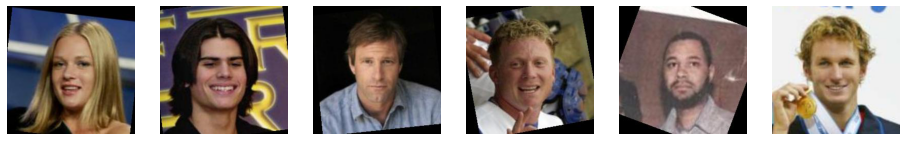

In [14]:
plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    img = imread(id_to_path[classid_to_ids[i][0]]) 
    plt.imshow(img)
    plt.axis('off')

Les images sont bien centrées sur les visages. On remarque toutefois que certaines présentent des bordures noires car les images ont été pivotées pour que le visage représenté soit centré. Est-ce que ces bordures noires impacteront l'entraînement du modèle ? 


### Preprocessing


On souhaite entraîner un réseau siamois, qui prend en entrée deux images $x_1$ et $x_2$ et donne en sortie une valeur représentant la similarité entre ces deux images.

On construit donc des ensembles de paires positives et négatives.

In [15]:
# Build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    
    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [16]:
# Build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
        
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
        
    return neg_pairs

La fonction suivante crée des ensembles de paires positives/négatives, qui constitueront nos jeux d'entraînement, de validation et de test. Plus précisemment, elle renvoie des arrays d'IDs que nous utiliserons par la suite dans un générateur (afin d'éviter de conserver les images ouvertes en mémoire).

Dans chaque jeu de données, il y a 50% de paires positives et 50% de paires négatives.

On sépare le jeu de données de la manière suivante : 60/20/20 (train, validation, test).

Classes représentées dans :
- Train : 0 à num_classes * 0.6
- Val : num_classes * 0.6 à num_classes * 0.8
- Test : num_classes * 0.8 à num_classes-1

In [17]:
# 50%/50% positive and negative pairs in each set
def build_train_val_test_data(train_ratio=0.6, val_ratio=0.2):
    listX1 = []
    listX2 = []
    listY = []
    #perm_classes = np.random.permutation(num_classes)
    range_classes = range(num_classes)
    train_classes = range_classes[:int(num_classes * train_ratio)]
    val_classes = range_classes[int(num_classes * train_ratio):int(num_classes * (train_ratio + val_ratio))]
    test_classes = range_classes[int(num_classes * (train_ratio + val_ratio)):]

    #train_split = int(num_classes * train_ratio)
    #val_split = int(num_classes * (train_ratio + val_ratio))
    #split = int(num_classes * split)
    #print(f"split={split}")
    
    # train : on le construit avec les images de class_id de 0 a split
    for class_id in train_classes:
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, list(train_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.RandomState(seed=42).permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # Validation set
    for id in val_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(val_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_val = np.array(listX1)
    X2_ids_val = np.array(listX2)
    Y_ids_val = np.array(listY)

    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in test_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(test_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    
    return (X1_ids_train, X2_ids_train, Y_ids_train, train_classes,
            X1_ids_val, X2_ids_val, Y_ids_val, val_classes,
            X1_ids_test, X2_ids_test, Y_ids_test, test_classes)

In [18]:
X1_ids_train, X2_ids_train, train_Y, train_classes, X1_ids_val, X2_ids_val, val_Y, val_classes, X1_ids_test, X2_ids_test, test_Y, test_classes = build_train_val_test_data()

In [19]:
X1_ids_train.shape, X2_ids_train.shape, train_Y.shape

((18336,), (18336,), (18336,))

In [20]:
X1_ids_val.shape, X2_ids_val.shape, val_Y.shape

((5700,), (5700,), (5700,))

In [21]:
X1_ids_test.shape, X2_ids_test.shape, test_Y.shape

((6410,), (6410,), (6410,))

Générateur

In [22]:
from skimage.io import imread
from skimage.transform import resize


def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)), 0)]
    return np.vstack(all_imgs)

In [23]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape

(13233, 60, 60, 3)

In [24]:
str(all_imgs.nbytes / 1e6) + "MB"

'1143.3312MB'

In [25]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(
        0.3,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    # You can add more transformation like random rotations, random change of luminance, etc.
])

In [26]:
feed_shape = (3, 60, 60)
training = True

In [27]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs, training=False):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        self.training = training
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]

        if training:
            imgs1 = seq.augment_images(imgs1)
            imgs2 = seq.augment_images(imgs2)
            
        targets = self.Y[low_index:high_index]
    
        return ([imgs1, imgs2], targets)

In [28]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs, training=True)

In [29]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 573


In [30]:
[x1, x2], y = gen[0]

x1.shape, x2.shape, y.shape

((32, 60, 60, 3), (32, 60, 60, 3), (32,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

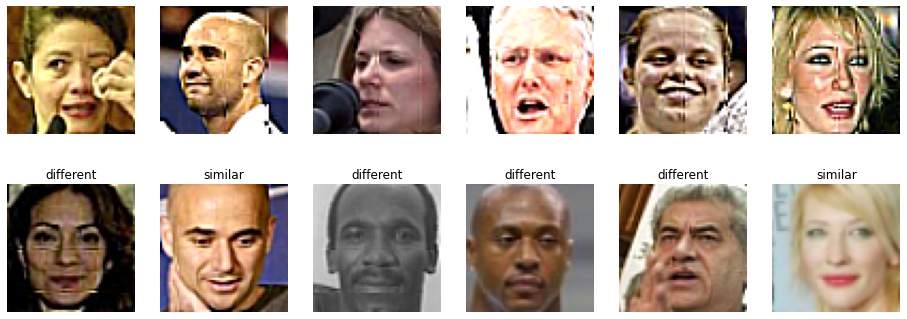

In [31]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
    
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
    
plt.show()

## Classifieur

In [32]:
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [33]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.

    Accuracy of the ability of the network to differentiate two people.
    '''
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

### From scratch

Generator

In [34]:
train_gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs, training=True)
#val_gen = Generator(X1_ids_val, X2_ids_val, val_Y, feed_shape=(3, 60, 60), training=False)

In [35]:
val_X1 = all_imgs[X1_ids_val]
val_X2 = all_imgs[X2_ids_val]

In [36]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

Model

In [37]:
# Define a configuration for your experiments
class ModelConfig(typing.NamedTuple):
    conv_layers: typing.List
    dense_layers: typing.List
    use_pool: bool
    use_dropout: bool

In [38]:
class SharedConv(tf.keras.Model):
    def __init__(self, config):
        super().__init__(self, name="sharedconv")

        self.config = config

        self.conv_layers = []
        for filters, kernel_size, stride in config.conv_layers:
            self.conv_layers.append(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), activation='relu'))

        self.dense_layers = []
        for units, activation in config.dense_layers:
            self.dense_layers.append(Dense(units=units, activation=activation))

        self.flatten = Flatten()
        
    def call(self, x):

        for conv in self.conv_layers:
            x = conv(x)
            if self.config.use_pool:
                x = MaxPool2D((2, 2))(x)

        x = self.flatten(x)

        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)

        return x

In [39]:
class Siamese(tf.keras.Model):
    def __init__(self, shared_conv):
        super().__init__(self, name="siamese")
        self.shared_conv = shared_conv
        self.dot = Dot(normalize=True, axes=1)
        
    def call(self, inputs):
        out1 = self.shared_conv(inputs[0]) # [bs=32, out_dim=50]
        out2 = self.shared_conv(inputs[1])
        dot = self.dot([out1, out2])
        
        return dot

In [40]:
def create_siamese_model(config):
    shared_conv = SharedConv(config)
    model = Siamese(shared_conv)
    model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_sim])
    return model

In [41]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()

Training


###### Config 1

In [ ]:
config1 = ModelConfig(
    conv_layers=[(128, 8, 4), (64, 4, 2), (8, 4, 1)],
    dense_layers=[(50, "sigmoid")],
    use_pool = False,
    use_dropout = False
)

In [ ]:
model = create_siamese_model(config1)

In [ ]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/baseline_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5) # Stop the training when no improv in val_loss for 5 epochs

In [ ]:
history = model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

In [ ]:
save_as_pickle("baseline_1.pkl", DRIVE_PATH+"/history", history)

INFO:tensorflow:Assets written to: ram://303f5d25-7cef-4f2a-94c3-0420a90ae52b/assets


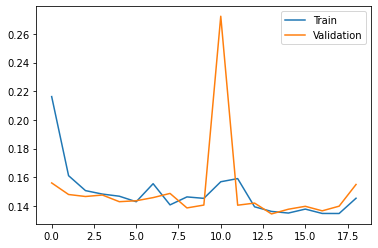

In [ ]:
plot_history(history)

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 1s 6ms/step - loss: 0.1543 - accuracy_sim: 0.5023
Test loss: 0.15432758629322052
Test (binary) classification accuracy based on similarity: 0.5023009777069092


Pas très bon résultat, pour le moment, le réseau prédit toujours la même chose, que pour deux images donnés, ce sont les mêmes personnes, et donc c'est pour ça qu'on a une acc_sim de 0.5...

In [ ]:
#baseline = create_siamese_model(config)
#baseline.load_weights(latest)

##### Config 2

In [ ]:
config2 = ModelConfig(
    conv_layers=[(128, 4, 1), (64, 4, 1), (32, 4, 1)],
    dense_layers=[(50, "sigmoid")],
    use_pool = True,
    use_dropout = True
)

In [ ]:
baseline2 = create_siamese_model(config2)

In [ ]:
num_model = 2
best_model_fname = f"{DRIVE_PATH}/models/baseline_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5) # Stop the training when no improv in val_loss for 5 epochs

In [ ]:
history2 = baseline2.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

Epoch 1/50
572/573 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy_sim: 0.5003
Epoch 1: val_accuracy_sim improved from -inf to 0.49756, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/baseline_2.ckpt
573/573 [==============================] - 28s 47ms/step - loss: 0.1612 - accuracy_sim: 0.5004 - val_loss: 0.2633 - val_accuracy_sim: 0.4976
Epoch 2/50
571/573 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy_sim: 0.4995
Epoch 2: val_accuracy_sim did not improve from 0.49756
573/573 [==============================] - 21s 37ms/step - loss: 0.1762 - accuracy_sim: 0.4997 - val_loss: 0.2764 - val_accuracy_sim: 0.4976
Epoch 3/50
571/573 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy_sim: 0.4998
Epoch 3: val_accuracy_sim did not improve from 0.49756
573/573 [==============================] - 15s 27ms/step - loss: 0.1747 - accuracy_sim: 0.4999 - val_loss: 0.2638 - val_accuracy_sim: 0.4976
Epoch 4/50
5

In [ ]:
save_as_pickle("baseline_2.pkl", DRIVE_PATH+"/history", history2)

INFO:tensorflow:Assets written to: ram://8eb65e9e-5497-47e5-b897-88d44364ce5a/assets


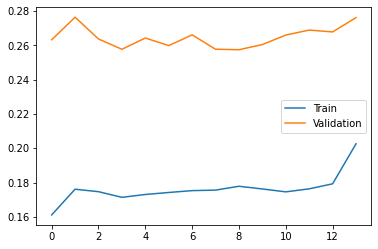

In [ ]:
plot_history(history2)

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = baseline2.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 2s 9ms/step - loss: 0.2758 - accuracy_sim: 0.4997
Test loss: 0.27575382590293884
Test (binary) classification accuracy based on similarity: 0.4996579587459564


### Pre-trained

VGG16 : entraîné sur plus de 14 million d'images en haute résolution appartenant à 1000 classes différentes.

In [42]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

On souhaite récupérer les couches de convolution du VGG16 pré-entraîné, pas la partie classifieur. Autrement dit, on souhaite utiliser les caractéristiques que le modèle a réussi à trouver.

Intégrer ces couches en tant que shared_conv du modèle siamois.

- include_top=False pour enlever les couches de classificaton
- Set the model as not trainable

In [43]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(60, 60, 3))
vgg16.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [44]:
class SharedConvPretrained(tf.keras.Model):
    def __init__(self, config, backbone):
        super().__init__(self, name="sharedconvpretrained")

        self.config = config
        self.backbone = backbone
        self.flatten = Flatten()
        self.dense_layers = [Dense(units, activation=activation) for units, activation in config.dense_layers]
        
    def call(self, x):

        x = self.backbone(x)
        x = self.flatten(x)
        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)
        return x

In [45]:
def create_pretrained_siamese_model(config, backbone=vgg16):
    shared_conv = SharedConvPretrained(config, backbone)
    model = Siamese(shared_conv)
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy_sim])
    return model

In [46]:
config1 = ModelConfig(
    conv_layers=[],
    dense_layers=[(100, "relu"), (50, "sigmoid")],
    use_pool = False,
    use_dropout = True
)

config2 = ModelConfig(
    conv_layers=[],
    dense_layers=[(300, "relu"), (100, "relu"), (50, "sigmoid")],
    use_pool = False,
    use_dropout = True
)

In [47]:
pretrained_model = create_pretrained_siamese_model(config1)
#pretrained_model.load_weights(f"{DRIVE_PATH}/models/pretrained_1.ckpt")

In [48]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/pretrained_newdataaug_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=10) # Stop the training when no improv in val_loss for 5 epochs

In [49]:
# 20 min
history = pretrained_model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

Epoch 1/50
573/573 [==============================] - ETA: 0s - loss: 0.1455 - accuracy_sim: 0.5023
Epoch 1: val_accuracy_sim improved from -inf to 0.49738, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/pretrained_newdataaug_1.ckpt
573/573 [==============================] - 60s 101ms/step - loss: 0.1455 - accuracy_sim: 0.5023 - val_loss: 0.1535 - val_accuracy_sim: 0.4974
Epoch 2/50
573/573 [==============================] - ETA: 0s - loss: 0.1446 - accuracy_sim: 0.5050
Epoch 2: val_accuracy_sim improved from 0.49738 to 0.49756, saving model to /content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images/models/pretrained_newdataaug_1.ckpt
573/573 [==============================] - 54s 94ms/step - loss: 0.1446 - accuracy_sim: 0.5050 - val_loss: 0.1531 - val_accuracy_sim: 0.4976
Epoch 3/50
573/573 [==============================] - ETA: 0s - loss: 0.1428 - accuracy_sim: 0.5057
Epoch 3: val_accuracy_sim improved from 0.49756 to 0.49808, saving model to /c

In [50]:
save_as_pickle("pretrained_newdataaug_1.pkl", DRIVE_PATH+"/history", history)

INFO:tensorflow:Assets written to: ram://1b6db8b1-79b9-457c-a70d-19a384628753/assets


In [ ]:
plot_history(history)

In [52]:
# Evaluation on test set
test_loss, test_acc_sim = pretrained_model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 7s 36ms/step - loss: 0.1302 - accuracy_sim: 0.5578
Test loss: 0.1301935464143753
Test (binary) classification accuracy based on similarity: 0.5578047633171082


In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = pretrained_model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 19s 35ms/step - loss: 0.1206 - accuracy_sim: 0.5967
Test loss: 0.12062393128871918
Test (binary) classification accuracy based on similarity: 0.5967040061950684


### Evaluation

Pour évaluer nos modèles, nous allons utiliser ... métriques différentes :
1. Accuracy@k
2. Precision (macro, weighted, micro)
3. Recall (macro, weighted, micro)

❗TODO ❗
Expliquer en détail ce que c'est et pourquoi on a choisi ces métriques (histoire du dataset déséquilibré)


---
NOTES BROUILLON

Classification binaire, 2 classes, positive et negative. 
- Acc : (TP+TN)/(TP+TN+FP+FN) -- Quelle proportion des samples (pos et neg) sont correctement classifiés ?
- Precision : TP / (TP + FP) -- Quelle proportion des prédictions positives sont réellement positives ?
- Recall : TP / (TP + FN) -- Quelle proportion des positives sont correctement classifiées ? 

Multi-class classification, 1 à N classes. On calcule métrique pour chaque classe. 
- Precision : 

Comment agréger métrique en une valeur ?
- Macro-averaged (macro) : moyenne
- Weighted : moyenne pondérée par le nombre de samples dans chaque classe 



- Top-k accuracy : la classe correcte se trouve dans le top-k des images les plus similaires 
- Top-k precision
- Top-k recall




Alors ici on veut evaluer notre classifieur sur le test set : 
- `test_classes=1150` classes, dont **334 classes avec plus d'une image**
- `all_ids_test=2468` images, dont **1171 images qui correspondent aux classes avec plus d'une image**
- `testclass_to_imgids`: à chaque test class avec plus d'une image, on associe les ids des images de la classe correspondante




Il faudra boucler sur les 1771 images

Calcul de metrique pour 334 classes ?



Par exemple, si je veux calculer métrique pour la class_id = 4601, qui a 3 images :
- précision : nombre de predictions correctes (TP) (ici entre 0 et 3 puisqu'il y a 3 images) / nombre total de predictions pour 4601
- recall : nombre de predictions correctes (TP) / nombre total de photos de 4601, donc 3 ici 


Ici on suppose que le modele donne une seule prédiction (on peut recuperer le top-1)





- Accuracy@k : nombre de fois ou le label correct est dans les k labels predits (ici les k classes les plus similaires à l'image en question)
    - Limite : unbalanced dataset
  
Seulement pour precision et recall :
- Macro https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    - Average (balanced acc dans le latex) : moyenne des métrique de chaque classe, chaque classe contribue identiquement au calcul de la metrique meme si proportion differente dans le dataset
    - Weighted = moyenne ponderee par contribution de chaque classe (nombre relatif d'examples de chaque classe)
- Micro : 
    - recall (somme des TP de chaque classe / somme des TP et FN de chaque classe)


In [ ]:
# Gather the ids of all images that are used for train and test
all_ids_train = list(set(X1_ids_train) | set(X2_ids_train))
all_ids_val = list(set(X1_ids_val) | set(X2_ids_val))
all_ids_test = list(set(X1_ids_test) | set(X2_ids_test))

#### **Construction du test set**

On construit notre jeu de données test pour l'évaluation de la classification, qui est différente du jeu de données test pour l'évaluation de la performance du modèle siamois sur la tâche de vérification. 

Ici notre `X_test` sera composé des IDs des images représentant des personnes avec plus d'une image. Il y a 1171 images au total.

In [ ]:
# List of images IDs of people with more than one image
X_test = []
for class_id in test_classes:
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        X_test += img_ids

L'élément `i` de `Y_test` correspond à la classe de l'image d'ID `i` dans `X_test`.

In [ ]:
# Ground truth labels of images in X_test
Y_test = [id_to_classid[i] for i in X_test]

In [ ]:
# Classes in X_test
X_test_classes = list(set(Y_test))

In [ ]:
print(f"{len(list(test_classes))} test classes, {len(X_test_classes)} classes with > 1 image.")
print(f"{len(all_ids_test)} test images, {len(X_test)} images corresponding to classes with > 1 image.")

1150 test classes, 334 classes with > 1 image.
2476 test images, 1771 images corresponding to classes with > 1 image.


#### **Fonctions pour l'évaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
#emb = pretrained_model.shared_conv.predict(all_imgs)
#emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)
emb = load_pickle("pretrained_1_emb.pkl", f"{DRIVE_PATH}/models")
pixelwise = np.reshape(all_imgs, (all_imgs.shape[0], 60*60*3))

In [ ]:
def most_sim(idx, topn=5, mode="cosine"):
    x = emb[idx]
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id, sims[id]) for id in ids[:topn]]
    elif mode == "euclidean":
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(pixelwise - pixelwise[idx], axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [ ]:
def accuracy_k(k=10, mode="embedding"):
    num_found = 0
    for img_idx in X_test:
        image_class = id_to_classid[img_idx]
        found_classes = []
        if mode == "embedding":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1)[1:]]
        elif mode == "random":
            found_classes = [id_to_classid[x] for x in random.sample(
                list(set(all_ids_test + all_ids_val + all_ids_train) - {img_idx}), k)]
        elif mode == "image":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, topn=k+1, mode="image")[1:]]
        
        if image_class in found_classes:
            num_found += 1
    return num_found / len(X_test)

In [ ]:
def predict_ground_truth(mode="embedding"):
    
    # Compute y_pred = estimated targets 
    y_pred = []
    for img_idx in X_test:
        image_class = id_to_classid[img_idx]
        if mode == "embedding":
            x = most_sim(img_idx, topn=2)[1:][0][0] # [1:] pour ne pas prendre l'image elle meme
        elif mode == "random":
            x = random.sample(list(set(all_ids_test + all_ids_val + all_ids_train) - {img_idx}), 1)[0]
        predicted_class = id_to_classid[x]
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    return y_pred

In [ ]:
def get_evaluation_metrics(y_pred, y_true, labels, average_modes):
    scores = {}
    for average_mode in average_modes:
        scores[f'{average_mode}-recall'] = recall_score(y_true, y_pred, labels=labels, average=average_mode)
        scores[f'{average_mode}-precision'] = precision_score(y_true, y_pred, labels=labels, average=average_mode)
    return scores

#### **Résultats**

In [ ]:
k_vals = [1, 5, 10, 20]
average_modes=["macro", "weighted", "micro"]

__1. Baseline (random)__

In [ ]:
print("Baseline results")
for k in k_vals:
    print(f'k={k} -- {accuracy_k(k, "random")}')

Baseline results
k=1 -- 0.001129305477131564
k=5 -- 0.004517221908526256
k=10 -- 0.01129305477131564
k=20 -- 0.028232636928289104


In [ ]:
y_pred_rand = predict_ground_truth(mode="random") # (1771, )
scores_rand = get_evaluation_metrics(y_pred=y_pred_rand, y_true=Y_test, labels=X_test_classes, average_modes=average_modes)

In [ ]:
scores_rand

{'macro-precision': 0.0016841317365269462,
 'macro-recall': 0.000270292747837658,
 'micro-precision': 0.00784313725490196,
 'micro-recall': 0.001129305477131564,
 'weighted-precision': 0.00846979107848673,
 'weighted-recall': 0.001129305477131564}

__2. From scratch__

__3. Pre-trained__

In [ ]:
# Accuracy@k
print("Pre-trained results")
for k in k_vals:
    print(f'k={k} -- {accuracy_k(k, "embedding")}')

Pre-trained results
k=1 -- 0.02258610954263128
k=5 -- 0.06945228684359118
k=10 -- 0.09937888198757763
k=20 -- 0.14793901750423488


In [ ]:
y_pred_emb = predict_ground_truth(mode="embedding") # (1771, )
scores_emb = get_evaluation_metrics(y_pred=y_pred_emb, y_true=Y_test, labels=X_test_classes, average_modes=average_modes)

In [ ]:
scores_emb

{'macro-precision': 0.046813515825491876,
 'macro-recall': 0.014883116200899887,
 'micro-precision': 0.14760147601476015,
 'micro-recall': 0.02258610954263128,
 'weighted-precision': 0.11368409023688526,
 'weighted-recall': 0.02258610954263128}

❗ TODO ❗

- Comment les interpréter ??
- Prendre du recul sur l'implementatio du predict ground truth aussi (on prend la photo avec la plus grande similarite, bcp d'erreurs ?)
- Explication par rapport à la distribution des classes dans le test aussi ? (Des images plus representees que d'autres)
- Régler histoire du division par zero dans precision_score

#### (Juste des tests brouillon)

In [ ]:
img_idx = 10650
classid = id_to_classid[img_idx]
k=5
predicted_id = most_sim(img_idx, topn=2)[1:][0][0]
predicted_class = id_to_classid[predicted_id]

In [ ]:
predicted_id, predicted_class, classid_to_name[predicted_class], classid

(1733, 792, 'Carlos_Quintanilla_Schmidt', 4601)

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
my_dot = Dot(normalize=True, axes=1)

def most_sim2(x, emb, topn=5):
    x_e = tf.expand_dims(x, axis=0)
    
    best_candidates_with_scores = list()
    
    for i, candidate in enumerate(emb):
        c_e = tf.expand_dims(candidate, axis=0)
        sim = float(my_dot([x_e, c_e]))
        
        best_candidates_with_scores.append((i, sim))
        best_candidates_with_scores = sorted(best_candidates_with_scores, key=lambda s: s[1])[-topn:]
        
    return best_candidates_with_scores

query: Richard_Krajicek 10650
nearest matches
Tim_Henman 12167 0.9647786021232605


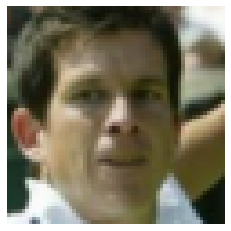

Colin_Powell 2247 0.9652083516120911


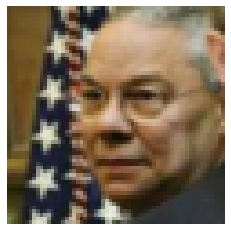

Andreas_Vinciguerra 579 0.9657827615737915


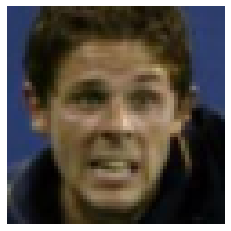

Carlos_Quintanilla_Schmidt 1733 0.981916606426239


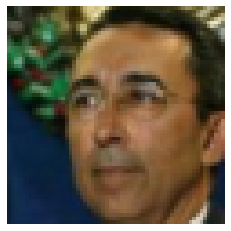

Richard_Krajicek 10650 1.0000001192092896


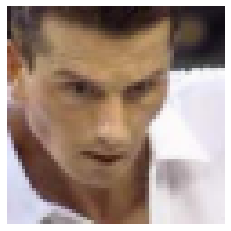

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
#class_id = random.choice(interesting_classes)[0]
class_id = id_to_classid[X_test[0]]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
# display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim2(emb[query_id], emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)    
    display(all_imgs[result_id])

## Attaques adverses


❗ TODO ❗
- **Printer que des images bien classifiees.**
- Poisoning attack (during training)
- Evasion attack (during testing)
    - White-box : FGSM, BIM
- Accuracies and adversarial accuracies

In [ ]:
def show_dataset_and_predictions(x, y):
    """
        Args:
            x (list): image IDs
            y (list): ground truth labels of each image in `x`
    """

    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        plt.subplot(3, 6, i + 1)
        plt.imshow(all_imgs[x[i]] / 255)
        plt.text(0, 2, s=f"y_true={classid_to_name[y[i]]}",
                bbox=dict(facecolor='blue', alpha=0.9),
                color="white")
        
        predicted_id = most_sim(x[i], topn=2)[1:][0][0]
        predicted_class = id_to_classid[predicted_id]
        #prediction = np.argmax(prediction)

        color = "green" if predicted_class == y[i] else "red"
        
        plt.text(0, 56, s=f"y_pred={classid_to_name[predicted_class]}",
                bbox=dict(facecolor=color, alpha=0.9),
                color="white")

        plt.axis("off")
    plt.show()

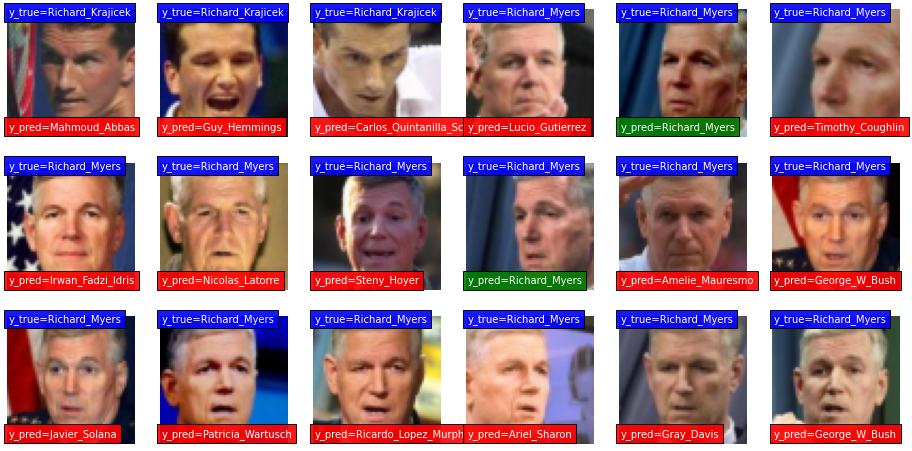

In [ ]:
show_dataset_and_predictions(X_test, Y_test)

### FGSM
White-box attack

- On ne peut attaquer que le test set de paires. Comment construire le test set de classification à partir du test set de verif attaqué ?
    - Récupérer la version attaquée dans l'un des deux sets attaqués d'id
- Merdouille : comment calculer le gradient par rapport à deux images ? OK

- model, prend en entree [b, 60, 60, 3]

In [ ]:
def fgsm(x_numpy, y_numpy, epsilon, model=model):
    x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32)
    y = tf.constant(tf.one_hot(y_numpy, num_classes))
    with tf.GradientTape() as g: 
        g.watch(x)

        p = model(x)
        loss = tf.keras.backend.categorical_crossentropy(target=y, output=tf.reshape(p, -1))
        dloss_dx = g.gradient(loss, x)
        gradient = np.sign(dloss_dx)
        x_attack = x + epsilon * gradient
        x_attack = np.reshape(x_attack, (28, 28))
        x_attack = np.clip(np.floor(x_attack), 0, 255)

    return x_attack


In [ ]:
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [ ]:
def fgsm_attack(x, dloss_dx, epsilon):
    gradient = np.sign(dloss_dx)
    x_attack = x + epsilon * gradient
    x_attack = np.reshape(x_attack, (60, 60, 3))
    x_attack = np.clip(np.floor(x_attack), 0, 255)

    return x_attack

In [ ]:
def fgsm_siamese(x1_numpy, x2_numpy, y, epsilon, model):
    """
        Args:
            y: 0 ou 1
    """
    x1 = tf.constant(np.expand_dims(x1_numpy, 0), dtype=tf.float32)
    x2 = tf.constant(np.expand_dims(x2_numpy, 0), dtype=tf.float32)
    #y = tf.constant(tf.one_hot(y_numpy, num_classes))

    with tf.GradientTape(persistent=True) as g: 
        g.watch(x1)
        g.watch(x2)

        y_pred = model((x1, x2))
        loss = contrastive_loss(y_true=y, y_pred=y_pred)

        dloss_dx1 = g.gradient(loss, x1)
        dloss_dx2 = g.gradient(loss, x2)
        
        x1_attack = fgsm_attack(x1, dloss_dx1, epsilon)
        x2_attack = fgsm_attack(x2, dloss_dx2, epsilon)

    return x1_attack, x2_attack

In [ ]:
x_pairs_fgsm = [fgsm_siamese(all_imgs[X1_ids_test[idx]], all_imgs[X2_ids_test[idx]], test_Y[idx], epsilon=5, model=pretrained_model) for idx in range(18)]

- Faire une fonction des paires des images attaquées, construire le test set
- Pour choix du paramètre epsilon : Faire une fonction qui plot l'image original et l'image attaquée pour voir si l'attaque est discernable à l'oeil nu ou pas
- Tester plusieurs normes ?
- Partie 3 : Une fois qu'on aura fixé epsilon, attaquer le modèle


In [ ]:
print(X1_ids_test[:10])
print(X2_ids_test[:10])
print(X_test[:10])

[10648 10649 10648 10650 10648 10650 10656 10660 10667 10656]
[10650 10650 10649 11230 13199 12789 10658 10662 10672 10670]
[10648, 10649, 10650, 10655, 10656, 10657, 10658, 10659, 10660, 10661]


Indices des images attaquees sont dans X1_ids_test 

In [ ]:
X_test_attack = [] # indice des images attaques dans x_pairs_fgsm[:][0]
for test_idx, test_id in enumerate(X_test):
    for x1_idx, x1_id in enumerate(X1_ids_test):
        if test_id == x1_id:
            


SyntaxError: ignored

In [ ]:
def show_dataset_and_attacks(x, x_attacks):
    """
        Args:
            x (list): image IDs
            y (list): ground truth labels of each image in `x`
    """

    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        plt.subplot(3, 6, i + 1)
        plt.imshow(all_imgs[x[i]] / 255)
        plt.text(0, 2, s=f"y_true={classid_to_name[y[i]]}",
                bbox=dict(facecolor='blue', alpha=0.9),
                color="white")
        
        predicted_id = most_sim(x[i], topn=2)[1:][0][0]
        predicted_class = id_to_classid[predicted_id]
        #prediction = np.argmax(prediction)

        color = "green" if predicted_class == y[i] else "red"
        
        plt.text(0, 56, s=f"y_pred={classid_to_name[predicted_class]}",
                bbox=dict(facecolor=color, alpha=0.9),
                color="white")

        plt.axis("off")
    plt.show()

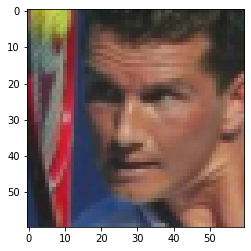

In [ ]:
plt.imshow(all_imgs[X1_ids_test[0]] / 255)

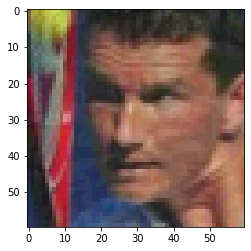

In [ ]:
plt.imshow(x_fgsm[0][0] / 255)